# Temporal Regularization for Control: Toy Example




### Loading Libraries and setting up environment

In [1]:
%reload_ext autoreload

In [2]:
from envs.ring_chain import RingChain
from envs.linear_risk_chain import LinearRiskChain
from agent import AgentNstepSARSA
from agent import AgentSARSA
import numpy as np
import pdb
import matplotlib.pyplot as plt

In [3]:
env = RingChain(horizon=10000)
# env = LinearRiskChain()

### Algorithms

#### Implementation in a function

In [4]:
def runSARSA(env, agent, randomStates, updateAllStates=False, nEpisodes=1, horizon=5000):
    MSE = []
    Qvals = []
    Qvals.append(agent.Q.copy())
    for ep in range(1):
        state = env.reset()
        action = agent.chooseActionEps(state)
        agent.initializeP(state)
        horizon = 5000
        for t in range(horizon):
            state2, reward, done, _ = env.step(action)
            action2 = agent.chooseActionEps(state2)
            agent.updatePolicySARSA(state, action, reward, state2, action2, randomStates)
            """ IMPORTANT: Change below line based on which MSE you wanna track """
            MSE.append(np.square(agent.Q[randomStates[0],:] - env.optimalQ[randomStates[0],:]).mean()) 
            Qvals.append(agent.Q.copy())
            state, action = state2, action2
            if(done):
                break
    return MSE, Qvals

In [11]:
def runNstepSARSA(env, agent, randomStates, updateAllStates=False, nEpisodes=1, horizon=5000):
    
    MSE = []
    
    for ep in range(nEpisodes):
        state = env.reset()
        action = agent.chooseActionEps(state)
        agent.state_memory[0], agent.action_memory[0] =  state, action
        T = horizon
        
        for t in range(T):
            if(t < T):
                state, reward, done, _ = env.step(action)
                agent.state_memory[t+1], agent.reward_memory[t+1] = state, reward
                if(done):
                    T = t + 1
                else:
                    action = agent.chooseActionEps(state)
                    agent.action_memory[t+1] = action
                    
            tau  = t - n + 1
            
            if(tau>=0):
                rewardsVector = agent.reward_memory[tau+1:np.minimum(tau+n,T)]
                discountingVector = np.power(agent.gamma, np.arange(0, rewardsVector.shape[0]))
                G = np.sum(np.multiply(rewardsVector, discountingVector))
                if(tau + n < T):
                    G = G + agent.gamma**n * agent.Q[agent.state_memory[tau + n].astype('int'), agent.action_memory[tau+n].astype('int')]
                if(updateAllStates):
                    agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')] += agent.alpha * (G - agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')])
                else:
                    if(agent.state_memory[tau].astype('int') in randomStates):
                        agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')] += agent.alpha * (G - agent.Q[agent.state_memory[tau].astype('int'), agent.action_memory[tau].astype('int')])
                
                """ IMPORTANT: Change below line based on which MSE you wanna track """
                MSE.append(np.square(agent.Q[randomStates[0],:] - env.optimalQ[randomStates[0],:]).mean())

            if(tau==T-1):
                break
                
    return MSE

#### Running the algorithms to generate plots

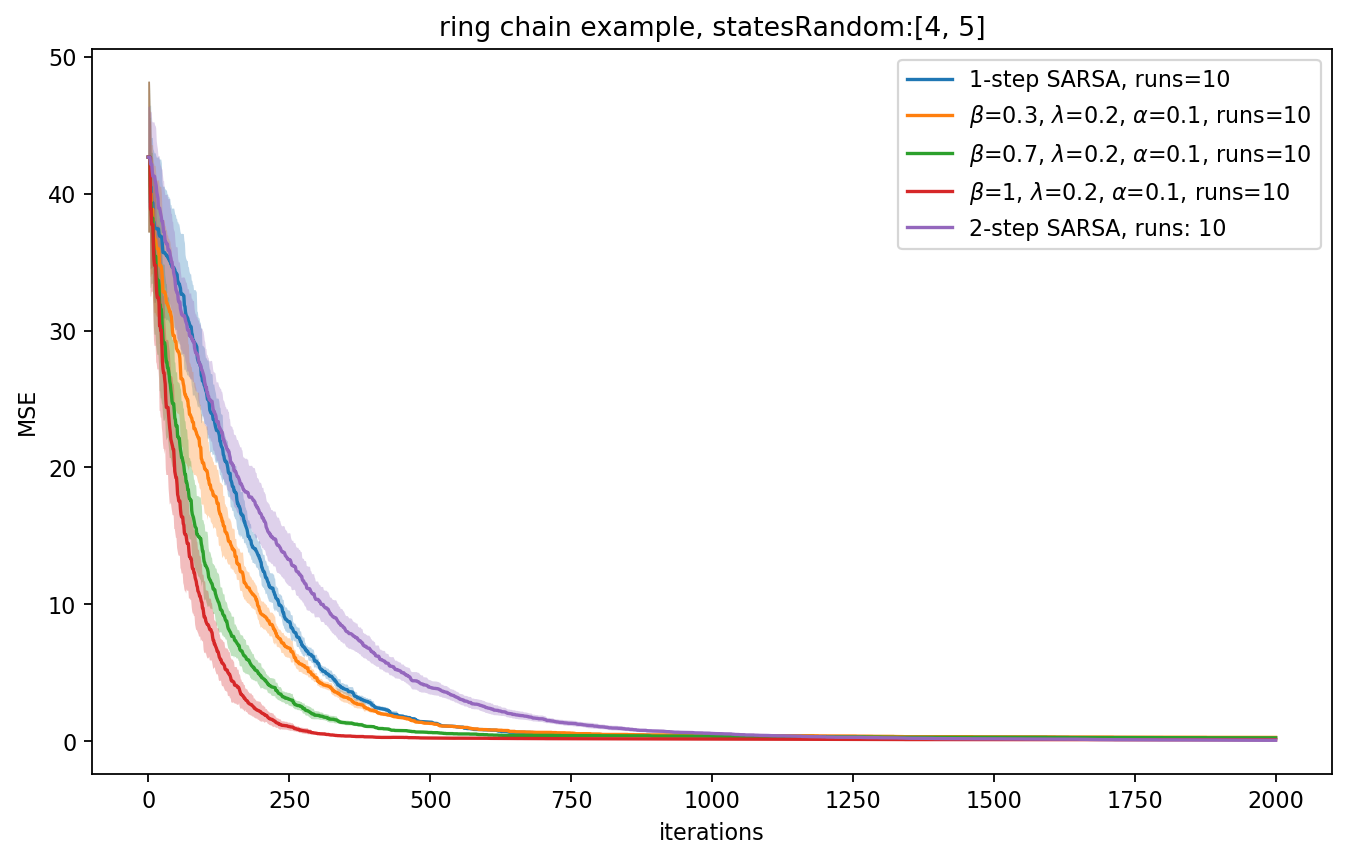

In [13]:
# Setting the states which have to be randomly initialized
randomStates = [4,5]
runs = 10 # Setting the number of runs
alpha = 0.1 # Setting the learning rate
plotEnd = 2000 # Setting the time step until which we need to plot
startSeed = 5

# Setting values of beta and lambda that need to be tested
betaVec = [0, 0.3, 0.7, 1]
lamVec = [0.2]

plt.figure(figsize=(10,6), dpi=160) # Creating a high res image to post results
# Looping through various values of beta, lambda for 1-step SARSA
for beta in betaVec:
    for lambd in lamVec:
        MSE_vec = [] # Array to store the MSE over multiple runs
        
        # Loop for various runs
        for seed in range(0, runs):
            
            # Creating an agent (it converges for epsDecay=True, eps=0.5 also)
            agent = AgentSARSA(env, epsDecay=False, eps=0.05, beta=beta, lambd=lambd, alpha=alpha)
            
            # Initializing the Qvalues
            agent.Q = env.optimalQ.copy()
            np.random.seed(seed + startSeed)
            agent.Q[randomStates,:] = np.random.rand(len(randomStates),2)*2+5
            
            # Calculating and store the mean squared error
            MSE, _ = runSARSA(env, agent, randomStates)
            MSE_vec.append(MSE)
        
        # Estimating mean and standard deviation over runs
        mu = np.mean(MSE_vec,axis=0)
        std = np.std(MSE_vec,axis=0)
        
        # Plotting the results
        if(beta==0):
            plt.plot(mu[:plotEnd], label=r'1-step SARSA, runs={}'.format(seed+1))
            plt.fill_between(range(plotEnd),mu[:plotEnd]-std[:plotEnd],mu[:plotEnd]+std[:plotEnd],alpha=0.3)
        else: 
            plt.plot(mu[:plotEnd], label=r'$\beta$={}, $\lambda$={}, $\alpha$={}, runs={}'.format(beta, lambd, alpha, seed+1))
            plt.fill_between(range(plotEnd),mu[:plotEnd]-std[:plotEnd],mu[:plotEnd]+std[:plotEnd],alpha=0.3)

   
# Running the algorithm for n-step methods
no_steps = 2 # Deciding on the value of n (needs to be >1)
MSE_vec = [] # Array to store the MSE over multiple runs

# Loop for various runs
for seed in range(0, runs):
    
    # Creating the agent
    agent = AgentNstepSARSA(env, no_steps=no_steps, eps=0.5, epsDecay=True)
    n = agent.no_steps
    
    # Initializing the values 
    agent.Q = env.optimalQ.copy()
    np.random.seed(seed + startSeed)
    agent.Q[randomStates,:] = np.random.rand(len(randomStates),2)*2+5
    
    
    MSE = runNstepSARSA(env, agent, randomStates)
    MSE_vec.append(MSE)
    
mu = np.mean(MSE_vec,axis=0)
std = np.std(MSE_vec,axis=0)/1.5

plt.plot(mu[:plotEnd], label=str(no_steps)+'-step SARSA, runs: ' + str(seed+1))
plt.fill_between(range(plotEnd),mu[:plotEnd]-std[:plotEnd],mu[:plotEnd]+std[:plotEnd],alpha=0.3)

# Plotting the results
plt.legend(), plt.xlabel('iterations'), plt.ylabel('MSE'), plt.title('ring chain example, statesRandom:' + str(randomStates))
plt.show()